In [2]:
import numpy as np


def make_random_dataset(
    num_samples,
    intercept,
    coefs,
    noise_amplitude,
    random_seed,
):
    np.random.seed(random_seed)
    num_features = len(coefs)
    X = np.random.randn(num_samples, num_features)
    noise = np.random.randn(num_samples) * noise_amplitude
    y = intercept + X.dot(coefs) + noise
    return X, y

In [ ]:
intercept = 1.0  # theta_0
coefs = np.array([2.0])  # (theta_1, theta_2, ..., theta_n)

num_samples = 100

noise_amplitude = 0.1
random_seed = 42

X, y = make_random_dataset(
    num_samples,
    intercept,
    coefs,
    noise_amplitude,
    random_seed,
)

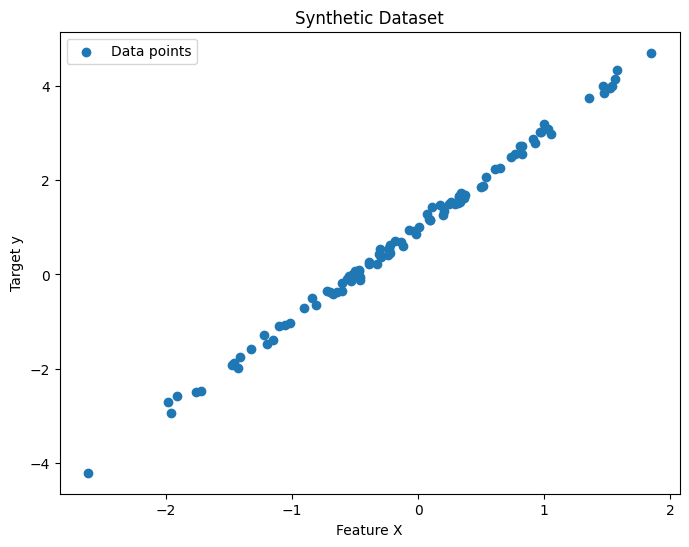

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X, y, label="Data points")
plt.xlabel("Feature X")
plt.ylabel("Target y")
plt.title("Synthetic Dataset")
plt.legend()
plt.show()

## Equação normal

Uso prático:

- Poucas features
- Número moderado de amostras

In [5]:
X_aumentado = np.hstack([np.ones((num_samples, 1)), X])

In [9]:
X[:5, :], X_aumentado[:5, :]

(array([[ 0.49671415],
        [-0.1382643 ],
        [ 0.64768854],
        [ 1.52302986],
        [-0.23415337]]),
 array([[ 1.        ,  0.49671415],
        [ 1.        , -0.1382643 ],
        [ 1.        ,  0.64768854],
        [ 1.        ,  1.52302986],
        [ 1.        , -0.23415337]]))

In [11]:
theta_otimo = np.linalg.inv(X_aumentado.T @ X_aumentado) @ X_aumentado.T @ y

In [12]:
theta_otimo

array([1.00074278, 1.98567428])

In [13]:
from sklearn.linear_model import LinearRegression

modelo = LinearRegression()

modelo.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [14]:
modelo.intercept_, modelo.coef_

(np.float64(1.0007427829863966), array([1.98567428]))

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin


class RegressaoLinearCaseira(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        # Constroi a matriz X aumentada com uma coluna de 1s para o intercepto.
        num_samples = X.shape[0]
        X_aumentado = np.hstack([np.ones((num_samples, 1)), X])

        # Calcula os coeficientes ótimos usando a equação normal.
        self.theta_otimo = (
            np.linalg.inv(X_aumentado.T @ X_aumentado) @ X_aumentado.T @ y
        )

        return self

    def predict(self, X):
        # Constroi a matriz X aumentada com uma coluna de 1s para o intercepto.
        num_samples = X.shape[0]
        X_aumentado = np.hstack([np.ones((num_samples, 1)), X])

        # Calcula as previsões.
        y_pred = X_aumentado @ self.theta_otimo

        return y_pred


In [16]:
modelo_caseiro = RegressaoLinearCaseira()

modelo_caseiro.fit(X, y)

modelo_caseiro.theta_otimo

array([1.00074278, 1.98567428])

## Gradient descent

Uso prático:

- Muitas features
- Número IMENSO de amostras - mas aqui tem um truque:
    - Ao invés de usar TODAS as amostras para calcular o GRADIENTE, use apenas ALGUMAS amostras escolhidas ao acaso
    - Mas troca de amostras escolhidas a cada passo, para cobrir o X completo.

$$
\nabla MSE(\theta) = \frac{2}{m} \left( X^T X \theta - X^T y\right)
$$

In [17]:
class RegressaoLinearGradiente(BaseEstimator, RegressorMixin):
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations

    def fit(self, X, y):
        num_samples, num_features = X.shape
        X_aumentado = np.hstack([np.ones((num_samples, 1)), X])

        # Inicializa os coeficientes (theta) com zeros.
        self.theta = np.zeros(num_features + 1)

        # Executa o gradiente descendente.
        for _ in range(self.num_iterations):
            gradiente = (2 / num_samples) * (
                X_aumentado.T @ (X_aumentado @ self.theta - y)
            )
            self.theta = self.theta - self.learning_rate * gradiente

        return self

    def predict(self, X):
        num_samples = X.shape[0]
        X_aumentado = np.hstack([np.ones((num_samples, 1)), X])

        y_pred = X_aumentado @ self.theta

        return y_pred

In [18]:
modelo_gradiente = RegressaoLinearGradiente(learning_rate=0.1, num_iterations=1000)

modelo_gradiente.fit(X, y)

modelo_gradiente.theta

array([1.00074278, 1.98567428])

## Problema: colinearidade!

In [19]:
X_ruim = np.hstack([X, X])

In [20]:
X[:5, :]

array([[ 0.49671415],
       [-0.1382643 ],
       [ 0.64768854],
       [ 1.52302986],
       [-0.23415337]])

In [21]:
X_ruim[:5, :]

array([[ 0.49671415,  0.49671415],
       [-0.1382643 , -0.1382643 ],
       [ 0.64768854,  0.64768854],
       [ 1.52302986,  1.52302986],
       [-0.23415337, -0.23415337]])

In [22]:
X_aumentado_ruim = np.hstack([np.ones((num_samples, 1)), X_ruim])  # Add intercept term

In [23]:
X_aumentado_ruim[:5, :]

array([[ 1.        ,  0.49671415,  0.49671415],
       [ 1.        , -0.1382643 , -0.1382643 ],
       [ 1.        ,  0.64768854,  0.64768854],
       [ 1.        ,  1.52302986,  1.52302986],
       [ 1.        , -0.23415337, -0.23415337]])

In [24]:
A = X_aumentado_ruim.T @ X_aumentado_ruim

In [25]:
A

array([[100.        , -10.38465174, -10.38465174],
       [-10.38465174,  82.73062939,  82.73062939],
       [-10.38465174,  82.73062939,  82.73062939]])

In [26]:
np.linalg.det(A)

np.float64(0.0)

In [27]:
np.linalg.inv(A)  # This will likely raise an error due to singularity

LinAlgError: Singular matrix